In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 8)

from get_draws.api import get_draws
from db_queries import get_ids

#from scipy import stats
from scipy.interpolate import griddata, RectBivariateSpline
# import re

# # Add path "vivarium_research_lsff/nanosim_models" to sys.path so imports will work from parent folder
# import sys, os.path
# # Note: Assuming pwd = vivarium_research_lsff/nanosim_models/notebooks
# sys.path.append(os.path.abspath(".."))

import lbwsg # in `vivarium_research_lsff/nanosim_models`
import lbwsg_plots # in `vivarium_research_lsff/nanosim_models`

import lbwsg_rr
import demography

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path
import yaml
import re
import pickle

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/lbwsg
ndbs
Wed Jan 12 18:14:11 PST 2022


# Goal: Test whether LBWSG relative risks from the interactive sim match the RRs I interpolate from BW and GA

- Over 91% of the 201,785 RRs match exactly (without even any floating point rounding differences)
- All the RRs at initialization are correct
- **17,638 (8.7%) of the RRs do NOT match. These are all in the Late Neonatal age group on day 28 of the sim**
- The bad RRs represent about 24% of all the Late Neonatal RRs on day 28. The remaining 76% of the late neonatal RRs on day 28 are correct
- The bad RRs do not match the early neonatal RRs either
- The bad RRs occur in every LBWSG category except the 4 TMREL categories
- The interpolators I created from scratch using GBD 2019 data produce identical RRs to the RRs produced by the pickled interpolators stored in the artifact
- The ages of simulants with mismatched RRs are uniformly distributed throughout the late neonatal age group

## Takeaway: This is weird. I don't know what's going on.

# Load output of interactive sim to see what it looks like

This simulation used `'draw_0'` for GBD data

In [2]:
!ls ../interactive_simulations/model_5/

lbwsg_data_5.2.0	    lbwsg_exposure_5.2.0.ipynb
lbwsg_data_5.2.0.csv	    model_5.0_lbwsg_exposure_updated.pdf
lbwsg_exposure_5.1.0.ipynb  model_5.1.1_lbwsg_exposure.pdf
lbwsg_exposure_5.1.1.ipynb  model_5.1.2_lbwsg_exposure_updated.pdf
lbwsg_exposure_5.1.2.ipynb  model_5.2.0_lbwsg_exposure_updated.pdf


In [3]:
sim_data = pd.read_pickle('../interactive_simulations/model_5/lbwsg_data_5.2.0')
sim_data

,age,sex,risk_factor.low_birth_weight_and_short_gestation_exposure,low_birth_weight.exposure,relative_risk,short_gestation.exposure,age_group,time_point
0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization
1,0.046464,Male,cat52,3448.290620,1.019543,38.995680,late_neonatal,initialization
2,0.052629,Female,cat42,2926.178834,2.288050,37.375198,late_neonatal,initialization
3,0.075327,Female,cat54,3681.270909,1.000000,39.985003,late_neonatal,initialization
...,...,...,...,...,...,...,...,...
201093,0.001250,Male,cat52,3290.490054,1.000000,39.547385,early_neonatal,28_days
201094,0.000131,Female,cat55,3726.968971,1.000000,40.190626,early_neonatal,28_days
201095,0.000854,Female,cat52,3270.917903,1.065181,38.170893,early_neonatal,28_days
201096,0.000397,Female,cat55,3594.525425,1.000000,40.189295,early_neonatal,28_days


In [4]:
sim_data.time_point.unique()

array(['initialization', '28_days'], dtype=object)

In [5]:
len(sim_data.loc[sim_data.time_point=='initialization'])

100000

In [6]:
len(sim_data.loc[sim_data.time_point=='28_days'])

101785

In [7]:
sim_data.age_group.unique()

array(['late_neonatal', 'early_neonatal'], dtype=object)

In [8]:
# looks like 201785 - 201097 = 688 simulants are duplicated
sim_data.index.nunique()

201097

In [9]:
# Find duplicate simulant ids
# keep='first' (default) means mark duplicated occurrences True except first one
sim_data.loc[sim_data.index.duplicated()]

,age,sex,risk_factor.low_birth_weight_and_short_gestation_exposure,low_birth_weight.exposure,relative_risk,short_gestation.exposure,age_group,time_point
157,0.027742,Male,cat23,1106.291696,79.297271,30.142248,late_neonatal,28_days
435,0.002667,Male,cat31,2282.386759,10.187393,40.465252,early_neonatal,28_days
827,0.060596,Male,cat43,2751.722732,2.857228,40.696543,late_neonatal,28_days
1045,0.049081,Male,cat31,2259.605415,7.786383,40.699952,late_neonatal,28_days
...,...,...,...,...,...,...,...,...
99349,0.014811,Male,cat42,2882.908786,1.852766,37.330684,early_neonatal,28_days
99416,0.057332,Male,cat25,1926.871273,14.347342,36.736977,late_neonatal,28_days
99509,0.069383,Female,cat32,2482.407503,4.603888,38.519435,late_neonatal,28_days
99841,0.076675,Male,cat51,3013.839258,1.741671,40.027683,late_neonatal,28_days


In [10]:
688+201097

201785

In [11]:
# Look at some duplicated simulants
sim_data.loc[[157, 99509, 99841]]

,age,sex,risk_factor.low_birth_weight_and_short_gestation_exposure,low_birth_weight.exposure,relative_risk,short_gestation.exposure,age_group,time_point
157,0.027742,Male,cat23,1106.291696,79.297271,30.142248,late_neonatal,initialization
157,0.027742,Male,cat23,1106.291696,79.297271,30.142248,late_neonatal,28_days
99509,0.000937,Female,cat32,2482.407503,3.664905,38.519435,early_neonatal,initialization
99509,0.069383,Female,cat32,2482.407503,4.603888,38.519435,late_neonatal,28_days
99841,0.000015,Male,cat51,3013.839258,1.382044,40.027683,early_neonatal,initialization
99841,0.076675,Male,cat51,3013.839258,1.741671,40.027683,late_neonatal,28_days


# Write function to process sim output for RR interpolation

In [12]:
age_group_to_age_group_id = {'early_neonatal': 2, 'late_neonatal': 3}
sex_to_sex_id = {'Male': 1, 'Female': 2}

def process_for_rr_interpolation(pop):
    """Ensures population has the columns expected by `lbwsg_rr.interpolate_lbwsg_rr_for_population`:
    'age_group_id', 'sex_id', birthweight', 'gestational_age'
    Ensures a unique index value for each row.
    Renames LBWSG category column for convenience.
    """
    pop = (
        pop.assign(
            age_group_id = pop['age_group'].map(age_group_to_age_group_id),
            sex_id = pop['sex'].map(sex_to_sex_id),
        )
        .rename(columns=
                {'low_birth_weight.exposure': 'birthweight',
                 'short_gestation.exposure':'gestational_age',
                 'risk_factor.low_birth_weight_and_short_gestation_exposure': 'lbwsg_category',
                })
        # Ensure a unique index for each row since some simulant ids were repeated
        .rename_axis(index='simulant_id')
        .reset_index()
    )
    return pop
pop = process_for_rr_interpolation(sim_data)
pop

,simulant_id,age,sex,lbwsg_category,birthweight,relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id
0,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1
1,1,0.046464,Male,cat52,3448.290620,1.019543,38.995680,late_neonatal,initialization,3,1
2,2,0.052629,Female,cat42,2926.178834,2.288050,37.375198,late_neonatal,initialization,3,2
3,3,0.075327,Female,cat54,3681.270909,1.000000,39.985003,late_neonatal,initialization,3,2
...,...,...,...,...,...,...,...,...,...,...,...
201781,201093,0.001250,Male,cat52,3290.490054,1.000000,39.547385,early_neonatal,28_days,2,1
201782,201094,0.000131,Female,cat55,3726.968971,1.000000,40.190626,early_neonatal,28_days,2,2
201783,201095,0.000854,Female,cat52,3270.917903,1.065181,38.170893,early_neonatal,28_days,2,2
201784,201096,0.000397,Female,cat55,3594.525425,1.000000,40.189295,early_neonatal,28_days,2,2


# Load LBWSG category data using lbwsg_rr module to convert dtypes

In [13]:
cat_df = lbwsg_rr.read_cat_df('lbwsg_category_data.csv')
cat_df

,lbwsg_category,parameter,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga_interval,ga_width,ga_midpoint,bw_interval,bw_width,bw_midpoint
0,cat2,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,cat116,cat116,20227,"Birth prevalence - [38, 40) wks, [1000, 1500) g",38,40,1000,1500,"[38, 40)",2,39.0,"[1000, 1500)",500,1250.0
55,cat117,cat117,20228,"Birth prevalence - [38, 40) wks, [1500, 2000) g",38,40,1500,2000,"[38, 40)",2,39.0,"[1500, 2000)",500,1750.0
56,cat123,cat123,20232,"Birth prevalence - [40, 42) wks, [1500, 2000) g",40,42,1500,2000,"[40, 42)",2,41.0,"[1500, 2000)",500,1750.0
57,cat124,cat124,20224,"Birth prevalence - [37, 38) wks, [1000, 1500) g",37,38,1000,1500,"[37, 38)",1,37.5,"[1000, 1500)",500,1250.0


# Load GBD relative risk data from my .hdf file on /share

In [14]:
!ls /share/scratch/users/ndbs/vivarium_lsff/gbd_data/

lbwsg_data.hdf		   multmodel_data.hdf
lsff_gbd_data_summary.hdf  stunting_prevalence_2019.hdf


In [15]:
lbwsg_hdf = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data/lbwsg_data.hdf'
hdf_rr_key = '/gbd_2019/relative_risk/diarrheal_diseases'

In [16]:
gbd_rr = lbwsg_rr.get_rr_data(lbwsg_hdf, hdf_rr_key)
gbd_rr

,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,cause_id,mortality,morbidity,metric_id,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,339,10810,1,2019,2,2,302,1,0,3,...,906.355930,1171.264520,1010.027950,986.421764,494.776193,537.871368,880.219326,796.623230,903.979011,943.601981
1,339,10810,1,2019,2,2,302,1,0,3,...,683.137849,824.643972,542.771578,633.041692,647.404629,478.471757,565.002324,703.592110,683.569330,769.060023
2,339,10810,1,2019,2,2,302,1,0,3,...,496.548577,501.217895,612.924435,507.091453,423.021838,367.708896,404.109679,466.427140,475.480542,494.876186
3,339,10810,1,2019,2,2,302,1,0,3,...,312.971545,273.942950,365.489360,297.644030,271.017682,218.688389,233.602302,236.271802,251.805871,241.935671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,339,10810,1,2019,3,1,302,1,0,3,...,2.620089,2.597227,2.735096,2.569520,2.851738,2.965840,2.555629,2.802927,3.147952,2.923688
229,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.211495,1.334712,1.226655,1.332490,1.286623,1.213633,1.119466,1.433590,1.298277
230,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
231,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Preprocess the RR data, and use it make the RR interpolators

In [17]:
draw_number = 0 # simulation data used draw 0
rr = lbwsg_rr.get_rr_data(gbd_rr, draw=draw_number, preprocess=True)
log_rr_interpolator = lbwsg_rr.make_lbwsg_log_rr_interpolator(rr, cat_df)
log_rr_interpolator

age_group_id  sex_id
2             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
3             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
Name: lbwsg_log_rr_interpolator, dtype: object

# Interpolate the RR's on the population from the simulation

In [18]:
%%time
interpolated_rrs_for_pop = lbwsg_rr.interpolate_lbwsg_rr_for_population(pop, log_rr_interpolator, cat_df)
interpolated_rrs_for_pop

CPU times: user 1.33 s, sys: 118 ms, total: 1.45 s
Wall time: 1.59 s


0         4.244653
1         1.019543
2         2.288050
3         1.000000
            ...   
201781    1.000000
201782    1.000000
201783    1.065181
201784    1.000000
Name: lbwsg_relative_risk, Length: 201785, dtype: float64

# Compare my interpolated RRs with the output of the sim

In [19]:
len(pop)

201785

In [20]:
# 183805 out of 201785 rows (91%) match EXACTLY
(interpolated_rrs_for_pop == pop['relative_risk']).sum()

183805

In [21]:
183805 / 201785

0.9108952598062294

In [22]:
# Hmm, but not all of the rest are close up to rounding errors...
np.allclose(interpolated_rrs_for_pop, pop['relative_risk'])

False

In [23]:
# This shows rows that are different
# There are 17,980 rows out of 201,785 that DON'T match exactly, or about 9%
interpolated_rrs_for_pop.compare(pop['relative_risk'])

,self,other
868,1.428091,1.428091
1914,1.058096,1.058096
2704,1.148311,1.148311
3209,1.934637,1.934637
...,...,...
197978,2.736533,2.736533
198717,14.504845,14.504845
200226,1.181786,1.181786
200717,61.656345,61.656345


In [24]:
# Spot check to see how big the differences are
interpolated_rrs_for_pop.loc[868]

1.4280913036888607

In [25]:
pop.loc[868, 'relative_risk']

1.428091303688861

In [26]:
# Try np.allclose with larger tolerances
# Still not working - that's suspicious...
np.allclose(interpolated_rrs_for_pop, pop['relative_risk'], rtol=1e-2, atol=1e-5)

False

In [27]:
# Check for NaN's
interpolated_rrs_for_pop.isna().any()

False

In [28]:
pop['relative_risk'].isna().any()

False

In [29]:
pop.isna().any().any()

False

# Dig more into differences...

In [30]:
# Wow, there are some unexpectedly large differences...
(interpolated_rrs_for_pop - pop['relative_risk']).describe()

count    201785.000000
mean         -0.086308
std           3.063392
min        -138.852523
25%           0.000000
50%           0.000000
75%           0.000000
max         163.185574
dtype: float64

In [31]:
pop.loc[interpolated_rrs_for_pop - pop['relative_risk'] > 1]

,simulant_id,age,sex,lbwsg_category,birthweight,relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id
100031,6280,0.059409,Male,cat20,1509.942073,51.172464,28.205887,late_neonatal,28_days,3,1
100045,8299,0.052815,Male,cat21,1403.287576,32.876203,29.233158,late_neonatal,28_days,3,1
100075,12498,0.071367,Male,cat25,1521.844525,30.453489,36.420847,late_neonatal,28_days,3,1
100138,22934,0.030731,Female,cat11,580.107602,149.513197,27.982640,late_neonatal,28_days,3,2
...,...,...,...,...,...,...,...,...,...,...,...
176476,175788,0.019851,Female,cat33,2972.646242,4.671273,33.099982,late_neonatal,28_days,3,2
176481,175793,0.020005,Male,cat33,2823.273060,5.940931,32.334716,late_neonatal,28_days,3,1
176494,175806,0.019469,Female,cat27,1846.523793,17.828105,31.413305,late_neonatal,28_days,3,2
176513,175825,0.020236,Female,cat44,2508.561986,2.282806,38.637763,late_neonatal,28_days,3,2


# Join my relative risks onto the population table to make things easier

In [32]:
pop1 = pop.join(interpolated_rrs_for_pop).rename(
    columns={'relative_risk': 'sim_relative_risk',
             'lbwsg_relative_risk': 'interp_relative_risk',
            }
)
pop1

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk
0,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1,4.244653
1,1,0.046464,Male,cat52,3448.290620,1.019543,38.995680,late_neonatal,initialization,3,1,1.019543
2,2,0.052629,Female,cat42,2926.178834,2.288050,37.375198,late_neonatal,initialization,3,2,2.288050
3,3,0.075327,Female,cat54,3681.270909,1.000000,39.985003,late_neonatal,initialization,3,2,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
201781,201093,0.001250,Male,cat52,3290.490054,1.000000,39.547385,early_neonatal,28_days,2,1,1.000000
201782,201094,0.000131,Female,cat55,3726.968971,1.000000,40.190626,early_neonatal,28_days,2,2,1.000000
201783,201095,0.000854,Female,cat52,3270.917903,1.065181,38.170893,early_neonatal,28_days,2,2,1.065181
201784,201096,0.000397,Female,cat55,3594.525425,1.000000,40.189295,early_neonatal,28_days,2,2,1.000000


In [33]:
pop1['interp_minus_sim'] = pop1['interp_relative_risk'] - pop1['sim_relative_risk']
pop1.loc[np.abs(pop1['interp_minus_sim'])>1]

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim
100013,2677,0.046006,Male,cat22,1051.667418,93.418710,33.728554,late_neonatal,28_days,3,1,53.410861,-40.007849
100017,3028,0.020884,Male,cat30,2310.902907,17.197403,32.846128,late_neonatal,28_days,3,1,9.125447,-8.071956
100031,6280,0.059409,Male,cat20,1509.942073,51.172464,28.205887,late_neonatal,28_days,3,1,62.590722,11.418258
100045,8299,0.052815,Male,cat21,1403.287576,32.876203,29.233158,late_neonatal,28_days,3,1,63.307482,30.431280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176491,175803,0.019247,Male,cat35,2375.243306,7.007161,37.376270,late_neonatal,28_days,3,1,5.658497,-1.348664
176494,175806,0.019469,Female,cat27,1846.523793,17.828105,31.413305,late_neonatal,28_days,3,2,23.447121,5.619015
176511,175823,0.019945,Female,cat33,2525.240608,12.352386,32.469460,late_neonatal,28_days,3,2,10.841493,-1.510893
176513,175825,0.020236,Female,cat44,2508.561986,2.282806,38.637763,late_neonatal,28_days,3,2,4.336479,2.053673


In [34]:
pop1.loc[np.abs(pop1['interp_minus_sim'])>0.5]

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim
100013,2677,0.046006,Male,cat22,1051.667418,93.418710,33.728554,late_neonatal,28_days,3,1,53.410861,-40.007849
100017,3028,0.020884,Male,cat30,2310.902907,17.197403,32.846128,late_neonatal,28_days,3,1,9.125447,-8.071956
100023,5221,0.076706,Female,cat44,2843.662339,1.704412,38.426052,late_neonatal,28_days,3,2,2.321376,0.616964
100031,6280,0.059409,Male,cat20,1509.942073,51.172464,28.205887,late_neonatal,28_days,3,1,62.590722,11.418258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176510,175822,0.019950,Female,cat48,3024.939987,1.523016,37.378777,late_neonatal,28_days,3,2,2.072116,0.549100
176511,175823,0.019945,Female,cat33,2525.240608,12.352386,32.469460,late_neonatal,28_days,3,2,10.841493,-1.510893
176513,175825,0.020236,Female,cat44,2508.561986,2.282806,38.637763,late_neonatal,28_days,3,2,4.336479,2.053673
176532,175844,0.019486,Female,cat41,3722.799820,3.509703,35.530529,late_neonatal,28_days,3,2,2.998594,-0.511109


In [35]:
pop1.loc[np.abs(pop1['interp_minus_sim'])>0.5, 'lbwsg_category'].unique()

array(['cat22', 'cat30', 'cat44', 'cat20', 'cat42', 'cat21', 'cat26',
       'cat25', 'cat19', 'cat96', 'cat11', 'cat37', 'cat95', 'cat28',
       'cat23', 'cat56', 'cat48', 'cat106', 'cat10', 'cat29', 'cat89',
       'cat41', 'cat45', 'cat24', 'cat35', 'cat117', 'cat39', 'cat14',
       'cat33', 'cat34', 'cat53', 'cat81', 'cat40', 'cat124', 'cat27',
       'cat49', 'cat31', 'cat90', 'cat88', 'cat38', 'cat32', 'cat80',
       'cat36', 'cat50', 'cat82', 'cat116', 'cat52', 'cat51', 'cat47',
       'cat17', 'cat46', 'cat43', 'cat123', 'cat15'], dtype=object)

In [36]:
len(pop1.loc[np.abs(pop1['interp_minus_sim'])>0.5, 'lbwsg_category'].unique())

54

In [37]:
pop1.loc[np.abs(pop1['interp_minus_sim'])>0.5, 'time_point'].unique()

array(['28_days'], dtype=object)

In [38]:
pop1.loc[np.abs(pop1['interp_minus_sim'])>0.1, 'time_point'].unique()

array(['28_days'], dtype=object)

In [39]:
len(pop1.loc[np.abs(pop1['interp_minus_sim'])>0.1])

16032

In [40]:
pop1.loc[np.abs(pop1['interp_minus_sim'])>0.1, 'age_group_id'].unique()

array([3])

In [41]:
pop1.loc[pop1['interp_relative_risk'] != pop1['sim_relative_risk']]

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim
868,868,0.059156,Male,cat51,3182.866179,1.428091,40.873982,late_neonatal,initialization,3,1,1.428091,-2.220446e-16
1914,1914,0.071714,Female,cat51,3466.528970,1.058096,40.980205,late_neonatal,initialization,3,2,1.058096,2.220446e-16
2704,2704,0.001312,Male,cat52,3136.316198,1.148311,39.179648,early_neonatal,initialization,2,1,1.148311,2.220446e-16
3209,3209,0.029376,Male,cat43,2997.892388,1.934637,40.884748,late_neonatal,initialization,3,1,1.934637,2.220446e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197978,197290,0.003302,Male,cat47,3786.147540,2.736533,36.543393,early_neonatal,28_days,2,1,2.736533,4.440892e-16
198717,198029,0.002334,Female,cat96,3891.341306,14.504845,33.658312,early_neonatal,28_days,2,2,14.504845,1.776357e-15
200226,199538,0.000096,Male,cat51,3139.227670,1.181786,40.787959,early_neonatal,28_days,2,1,1.181786,2.220446e-16
200717,200029,0.000653,Male,cat123,1597.616303,61.656345,41.058405,early_neonatal,28_days,2,1,61.656345,-7.105427e-15


In [42]:
pop1.loc[np.abs(pop1['interp_minus_sim'])>1e-8, 'age_group_id'].unique()

array([3])

In [43]:
len(pop1.loc[np.abs(pop1['interp_minus_sim'])>1e-8])

17638

# Ok, my guess is that RR's are not getting reset as simulants move from ENN to LNN -- let's test this

## Nope, they're different from the ENN RR's too

In [44]:
pop_bad = pop1.loc[np.abs(pop1['interp_minus_sim'])>1e-8]
pop_bad

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim
100013,2677,0.046006,Male,cat22,1051.667418,93.418710,33.728554,late_neonatal,28_days,3,1,53.410861,-40.007849
100017,3028,0.020884,Male,cat30,2310.902907,17.197403,32.846128,late_neonatal,28_days,3,1,9.125447,-8.071956
100023,5221,0.076706,Female,cat44,2843.662339,1.704412,38.426052,late_neonatal,28_days,3,2,2.321376,0.616964
100031,6280,0.059409,Male,cat20,1509.942073,51.172464,28.205887,late_neonatal,28_days,3,1,62.590722,11.418258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176521,175833,0.019635,Female,cat44,2949.066751,1.592122,38.639886,late_neonatal,28_days,3,2,2.045860,0.453738
176529,175841,0.020213,Male,cat43,2564.335132,4.051588,40.781251,late_neonatal,28_days,3,1,4.212335,0.160747
176532,175844,0.019486,Female,cat41,3722.799820,3.509703,35.530529,late_neonatal,28_days,3,2,2.998594,-0.511109
176539,175851,0.020138,Female,cat48,3206.340869,1.211190,37.900386,late_neonatal,28_days,3,2,1.616581,0.405392


In [45]:
# Interpolate using early neonatal RRs instead of late neonatal
enn_rrs_for_pop_bad = lbwsg_rr.interpolate_lbwsg_rr_for_population(
    pop_bad.assign(age_group_id=2), log_rr_interpolator, cat_df)
enn_rrs_for_pop_bad

100013    88.235906
100017    19.648759
100023     1.405077
100031    94.825500
            ...    
176521     1.242587
176529     4.067406
176532     5.929748
176539     1.131304
Name: lbwsg_relative_risk, Length: 17638, dtype: float64

In [46]:
enn_rrs_for_pop_bad == pop_bad['sim_relative_risk']

100013    False
100017    False
100023    False
100031    False
          ...  
176521    False
176529    False
176532    False
176539    False
Length: 17638, dtype: bool

In [47]:
# Compare early neonatal RRs with those from sim
(enn_rrs_for_pop_bad - pop_bad['sim_relative_risk']).describe()

count    17638.000000
mean         2.128121
std         12.746739
min        -98.696312
25%         -0.780039
50%         -0.131208
75%          1.029527
max        231.443452
dtype: float64

In [48]:
# Compare late neonatal RRs with those from sim
(pop_bad['interp_relative_risk'] - pop_bad['sim_relative_risk']).describe()

count    17638.000000
mean        -0.987389
std         10.318737
min       -138.852523
25%         -0.724002
50%         -0.103172
75%          0.334354
max        163.185574
dtype: float64

In [75]:
# Look at absolute deviation between late neonatal RRs and RRs from sim
np.abs(pop_bad['interp_relative_risk'] - pop_bad['sim_relative_risk']).describe()

count    17638.000000
mean         3.140716
std          9.878596
min          0.000068
25%          0.232273
50%          0.492923
75%          1.491567
max        163.185574
dtype: float64

In [76]:
# Double-check that bad RR's are only at 28-day time point
pop_bad.time_point.unique()

array(['28_days'], dtype=object)

In [77]:
# Double-check that bad RR's are only in late neonatal age group
pop_bad.age_group.unique()

array(['late_neonatal'], dtype=object)

# Check whether ANY late neonatal RR's at day 28 are correct

Yes, about 76% of them are correct.

In [49]:
pop1.query("time_point=='28_days' and age_group_id==3 and -1e-8 < interp_minus_sim < 1e-8")

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim
100000,157,0.027742,Male,cat23,1106.291696,79.297271,30.142248,late_neonatal,28_days,3,1,79.297271,0.0
100002,827,0.060596,Male,cat43,2751.722732,2.857228,40.696543,late_neonatal,28_days,3,1,2.857228,0.0
100003,1045,0.049081,Male,cat31,2259.605415,7.786383,40.699952,late_neonatal,28_days,3,1,7.786383,0.0
100004,1053,0.076665,Female,cat42,2644.821981,3.290949,37.801444,late_neonatal,28_days,3,2,3.290949,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176537,175849,0.019206,Male,cat54,3563.357145,1.000000,38.449458,late_neonatal,28_days,3,1,1.000000,0.0
176538,175850,0.019392,Male,cat54,3923.430842,1.000000,38.093351,late_neonatal,28_days,3,1,1.000000,0.0
176540,175852,0.019251,Male,cat117,1960.439743,13.935619,39.687083,late_neonatal,28_days,3,1,13.935619,0.0
176541,175853,0.020420,Male,cat43,2504.169811,4.855961,41.746385,late_neonatal,28_days,3,1,4.855961,0.0


In [50]:
pop1.query("time_point=='28_days' and age_group_id==3 and (interp_minus_sim > 1e-8 or interp_minus_sim < -1e-8)")

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim
100013,2677,0.046006,Male,cat22,1051.667418,93.418710,33.728554,late_neonatal,28_days,3,1,53.410861,-40.007849
100017,3028,0.020884,Male,cat30,2310.902907,17.197403,32.846128,late_neonatal,28_days,3,1,9.125447,-8.071956
100023,5221,0.076706,Female,cat44,2843.662339,1.704412,38.426052,late_neonatal,28_days,3,2,2.321376,0.616964
100031,6280,0.059409,Male,cat20,1509.942073,51.172464,28.205887,late_neonatal,28_days,3,1,62.590722,11.418258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176521,175833,0.019635,Female,cat44,2949.066751,1.592122,38.639886,late_neonatal,28_days,3,2,2.045860,0.453738
176529,175841,0.020213,Male,cat43,2564.335132,4.051588,40.781251,late_neonatal,28_days,3,1,4.212335,0.160747
176532,175844,0.019486,Female,cat41,3722.799820,3.509703,35.530529,late_neonatal,28_days,3,2,2.998594,-0.511109
176539,175851,0.020138,Female,cat48,3206.340869,1.211190,37.900386,late_neonatal,28_days,3,2,1.616581,0.405392


In [51]:
57139/(17638+57139)

0.7641253326557631

# Look at ratio of RRs, and look at the difference of RRs in log space

This might be a more informative way to compare the RRs than to look at differences, since the interpolation happens in log space.

In [52]:
(pop1.interp_relative_risk / pop1.sim_relative_risk).describe()

count    201785.000000
mean          1.000187
std           0.108193
min           0.026243
25%           1.000000
50%           1.000000
75%           1.000000
max           3.586845
dtype: float64

In [53]:
np.log(pop1.interp_relative_risk / pop1.sim_relative_risk).describe()

count    201785.000000
mean         -0.006957
std           0.138451
min          -3.640343
25%           0.000000
50%           0.000000
75%           0.000000
max           1.277273
dtype: float64

# Save population table with both relative risk columns

In [54]:
pop1.to_pickle('lbwsg_data_5.2.0_with_interp_rrs.pickle.zip')

In [55]:
df = pd.read_pickle('lbwsg_data_5.2.0_with_interp_rrs.pickle.zip')
df

,simulant_id,age,sex,lbwsg_category,birthweight,sim_relative_risk,gestational_age,age_group,time_point,age_group_id,sex_id,interp_relative_risk,interp_minus_sim
0,0,0.044994,Male,cat40,2580.395737,4.244653,36.164988,late_neonatal,initialization,3,1,4.244653,0.0
1,1,0.046464,Male,cat52,3448.290620,1.019543,38.995680,late_neonatal,initialization,3,1,1.019543,0.0
2,2,0.052629,Female,cat42,2926.178834,2.288050,37.375198,late_neonatal,initialization,3,2,2.288050,0.0
3,3,0.075327,Female,cat54,3681.270909,1.000000,39.985003,late_neonatal,initialization,3,2,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201781,201093,0.001250,Male,cat52,3290.490054,1.000000,39.547385,early_neonatal,28_days,2,1,1.000000,0.0
201782,201094,0.000131,Female,cat55,3726.968971,1.000000,40.190626,early_neonatal,28_days,2,2,1.000000,0.0
201783,201095,0.000854,Female,cat52,3270.917903,1.065181,38.170893,early_neonatal,28_days,2,2,1.065181,0.0
201784,201096,0.000397,Female,cat55,3594.525425,1.000000,40.189295,early_neonatal,28_days,2,2,1.000000,0.0


In [56]:
df.equals(pop1)

True

# Load Artifact interpolators and compare to the ones above

In [57]:
artifact_path = '/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf'
art = Artifact(artifact_path, filter_terms=['year_start == 2019', f'age_end <= 5'])
art_lbwsg_rr_interpolator = art.load(f'risk_factor.low_birth_weight_and_short_gestation.relative_risk_interpolator')
art_lbwsg_rr_interpolator

draw_0  \
sex    age_start age_end  year_start year_end                                                      
Female 0.000000  0.019178 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.019178  0.076712 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.500000  1.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
...                                                                                          ...   
Male   0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.500000  1.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       1.000000  2.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       2.000000  5.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   

                                                                                          draw_1  \
sex    age_start age_end  year_start year_end                                                      
Female 0.000000  0.019178 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.019178  0.076712 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.500000  1.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
...                                                                                          ...   
Male   0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.500000  1.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       1.000000  2.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       2.000000  5.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   

                                                                                          draw_2  \
sex    age_start age_end  year_start year_end                                                      
Female 0.000000  0.019178 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.019178  0.076712 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.500000  1.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
...                                                                                          ...   
Male   0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.500000  1.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       1.000000  2.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       2.000000  5.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   

                                                                                          draw_3  \
sex    age_start age_end  year_start year_end                                                      
Female 0.000000  0.019178 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.019178  0.076712 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
       0.500000  1.000000 2019       2020      80049582060000000000008c1a73636970792e696e7465...   
...                                                                                          ...   
Male   0.076712  0.500000 2019       2020      80049582060000000000008c1a73636970792e69

In [58]:
age_bins = art.load('population.age_bins')
age_bins

,,,age_group_id
age_start,age_end,age_group_name,
0.000000,0.019178,Early Neonatal,2
0.019178,0.076712,Late Neonatal,3
0.076712,0.500000,1-5 months,388
0.500000,1.000000,6-11 months,389
1.000000,2.000000,12 to 23 months,238
2.000000,5.000000,2 to 4,34


## Write function to add id's to the artifact dataframe's index

In [59]:
def add_ids_to_index(artifact_df, age_bins, sex_to_sex_id):
    age_bins_index_empty_df = age_bins.set_index('age_group_id', append=True)
    sex_index_empty_df = (
        pd.DataFrame({'sex_id': sex_to_sex_id})
        .rename_axis(index='sex')
        .set_index('sex_id', append=True)
    )
    return artifact_df.join(sex_index_empty_df).join(age_bins_index_empty_df)
add_ids_to_index(art_lbwsg_rr_interpolator, age_bins, sex_to_sex_id)

draw_0  \
age_start age_end  sex    year_start year_end sex_id age_group_name  age_group_id                                                      
0.000000  0.019178 Female 2019       2020     2      Early Neonatal  2             80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      Early Neonatal  2             80049582060000000000008c1a73636970792e696e7465...   
0.019178  0.076712 Female 2019       2020     2      Late Neonatal   3             80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      Late Neonatal   3             80049582060000000000008c1a73636970792e696e7465...   
...                                                                                                                              ...   
1.000000  2.000000 Female 2019       2020     2      12 to 23 months 238           80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      12 to 23 months 238           80049582060000000000008c1a73636970792e696e7465...   
2.000000  5.000000 Female 2019       2020     2      2 to 4          34            80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      2 to 4          34            80049582060000000000008c1a73636970792e696e7465...   

                                                                                                                              draw_1  \
age_start age_end  sex    year_start year_end sex_id age_group_name  age_group_id                                                      
0.000000  0.019178 Female 2019       2020     2      Early Neonatal  2             80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      Early Neonatal  2             80049582060000000000008c1a73636970792e696e7465...   
0.019178  0.076712 Female 2019       2020     2      Late Neonatal   3             80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      Late Neonatal   3             80049582060000000000008c1a73636970792e696e7465...   
...                                                                                                                              ...   
1.000000  2.000000 Female 2019       2020     2      12 to 23 months 238           80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      12 to 23 months 238           80049582060000000000008c1a73636970792e696e7465...   
2.000000  5.000000 Female 2019       2020     2      2 to 4          34            80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      2 to 4          34            80049582060000000000008c1a73636970792e696e7465...   

                                                                                                                              draw_2  \
age_start age_end  sex    year_start year_end sex_id age_group_name  age_group_id                                                      
0.000000  0.019178 Female 2019       2020     2      Early Neonatal  2             80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      Early Neonatal  2             80049582060000000000008c1a73636970792e696e7465...   
0.019178  0.076712 Female 2019       2020     2      Late Neonatal   3             80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020     1      Late Neonatal   3             80049582060000000000008c1a73636970792e696e7465...   
...                                                                                                                              ...   
1.000000  2.000000 Female 2019       2020     2      12 to 23 months 238           80049582060000000000008c1a73636970792e696e7465...   
                   Male   2019       2020   

## Write function to unpickle the artifact interpolators

In [61]:
def unpickle_artifact_interpolators(art_interpolators, draw_number):
    art_interpolators = (
        art_interpolators[f'draw_{draw_number}']
        .map(lambda byte_string: pickle.loads(bytes.fromhex(byte_string)))
    )
    return art_interpolators

unpickle_artifact_interpolators(art_lbwsg_rr_interpolator, draw_number)

sex     age_start  age_end   year_start  year_end
Female  0.000000   0.019178  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
        0.019178   0.076712  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
        0.076712   0.500000  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
        0.500000   1.000000  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
                                                                           ...                        
Male    0.076712   0.500000  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
        0.500000   1.000000  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
        1.000000   2.000000  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
        2.000000   5.000000  2019        2020        <scipy.interpolate.fitpack2.RectBivariateSplin...
Name: draw_0, Length: 1

## Write a function to conform the index columns of the artifact interpolators to match mine

In [62]:
def conform_index_columns(artifact_df):
    artifact_df = (
        artifact_df.reset_index(
            ['age_start', 'age_end', 'sex', 'year_start', 'year_end', 'age_group_name'],
        drop=True)
        .reorder_levels(['age_group_id', 'sex_id'])
    )
    return artifact_df

art_interpolators = (
    art_lbwsg_rr_interpolator
    .pipe(add_ids_to_index, age_bins, sex_to_sex_id)
    .pipe(conform_index_columns) # Id's must be added to index bfore calling conform_index_columns
    .pipe(unpickle_artifact_interpolators, draw_number)
)
art_interpolators

age_group_id  sex_id
2             2         <scipy.interpolate.fitpack2.RectBivariateSplin...
              1         <scipy.interpolate.fitpack2.RectBivariateSplin...
3             2         <scipy.interpolate.fitpack2.RectBivariateSplin...
              1         <scipy.interpolate.fitpack2.RectBivariateSplin...
                                              ...                        
238           2         <scipy.interpolate.fitpack2.RectBivariateSplin...
              1         <scipy.interpolate.fitpack2.RectBivariateSplin...
34            2         <scipy.interpolate.fitpack2.RectBivariateSplin...
              1         <scipy.interpolate.fitpack2.RectBivariateSplin...
Name: draw_0, Length: 12, dtype: object

## Reindex the artifact interpolators to match my interpolators

In [63]:
art_interpolators_reindexed = art_interpolators.reindex(log_rr_interpolator.index)
art_interpolators_reindexed

age_group_id  sex_id
2             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
3             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
Name: draw_0, dtype: object

In [64]:
log_rr_interpolator

age_group_id  sex_id
2             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
3             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
Name: lbwsg_log_rr_interpolator, dtype: object

## Compare the artifact interpolator objects with my interpolator objects

### They're all different. But I don't know how object comparison is working, so the interpolators could still potenially represent the same function

In [65]:
art_interpolators_reindexed.equals(log_rr_interpolator)

False

In [66]:
art_interpolators_reindexed == log_rr_interpolator

age_group_id  sex_id
2             1         False
              2         False
3             1         False
              2         False
dtype: bool

# Interpolate the population using the artifact interpolators and compare

## First compare using all age groups with using only ENN and LNN -- they're the same

In [67]:
%%time
# Interpolators include all 6 age groups
art_interpolated_rrs_for_pop_all = lbwsg_rr.interpolate_lbwsg_rr_for_population(
    pop, art_interpolators, cat_df)
art_interpolated_rrs_for_pop_all

CPU times: user 1.12 s, sys: 62.6 ms, total: 1.18 s
Wall time: 1.29 s


0         4.244653
1         1.019543
2         2.288050
3         1.000000
            ...   
201781    1.000000
201782    1.000000
201783    1.065181
201784    1.000000
Name: lbwsg_relative_risk, Length: 201785, dtype: float64

In [68]:
%%time
# Interpolators include only ENN and LNN age groups
art_interpolated_rrs_for_pop_nn = lbwsg_rr.interpolate_lbwsg_rr_for_population(
    pop, art_interpolators_reindexed, cat_df)
art_interpolated_rrs_for_pop_nn

CPU times: user 1.08 s, sys: 98.6 ms, total: 1.18 s
Wall time: 1.18 s


0         4.244653
1         1.019543
2         2.288050
3         1.000000
            ...   
201781    1.000000
201782    1.000000
201783    1.065181
201784    1.000000
Name: lbwsg_relative_risk, Length: 201785, dtype: float64

In [69]:
art_interpolated_rrs_for_pop_all.equals(art_interpolated_rrs_for_pop_nn)

True

## Now compare artifact interpolated RRs with my interpolated RRs above

### They're the same!

In [70]:
# Artifact interpolators included all 6 age groups
art_interpolated_rrs_for_pop_all.equals(interpolated_rrs_for_pop)

True

In [71]:
# Artifact interpolators only included the 2 neonatal age groups
art_interpolated_rrs_for_pop_nn.equals(interpolated_rrs_for_pop)

True

In [72]:
# And we get the same number of RR's not matching the sim RR's
art_interpolated_rrs_for_pop_nn.compare(pop1.sim_relative_risk)

,self,other
868,1.428091,1.428091
1914,1.058096,1.058096
2704,1.148311,1.148311
3209,1.934637,1.934637
...,...,...
197978,2.736533,2.736533
198717,14.504845,14.504845
200226,1.181786,1.181786
200717,61.656345,61.656345


# Check the age distribution of the population with mismatched RRs

It looks uniformly distributed in the late neonatal age group.

<AxesSubplot:>

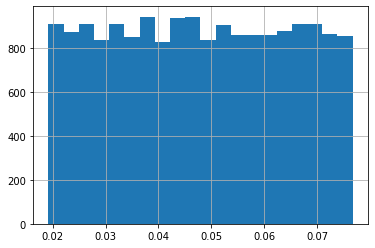

In [73]:
pop_bad.age.hist(bins=20)

# Well, I don't know what's going on.